Import of libraries

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tabulate import tabulate                    #allows to represent information in table format
pd.set_option("display.max_columns", None)       #this allows to show all possible columns

1) https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset

2) https://www.kaggle.com/datasets/mirichoi0218/insurance

3) https://www.kaggle.com/datasets/erdemtaha/cancer-data

# Part 1. Unsupervised learning

In [247]:
df_original = pd.read_excel("Online Retail.xlsx")
df_original.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [248]:
df_original.shape

(541909, 8)

In [249]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in df_original:
    table.append([column] + columnValues(df_original[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column         Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
-----------  --------------  -------------  -------------  ------------  -----------  ----------  --------------
InvoiceNo             25900            4.8              0           0              0         0    object
StockCode              4070            0.8              0           0              0         0    object
Description            4223            0.8              0           0           1454         0.3  object
Quantity                722            0.1              0           0              0         0    int64
InvoiceDate           23260            4.3              0           0              0         0    datetime64[ns]
UnitPrice              1630            0.3           2515           0.5            0         0    float64
CustomerID             4372            0.8              0           0         135080        24.9  float64
Country                  38        

In [250]:
df_original.drop(columns="CustomerID",inplace=True)

In [251]:
def columnValues(df):
    row = [df.mean(), df.median(), df.std(), df.min(), df.max()]
    return row

table = []
for column in df_original.select_dtypes(include=np.number):
    table.append([column] + columnValues(df_original[column]))

print(tabulate(table, headers=["Column","Mean","Median","Std","Min","Max"], tablefmt="orgbtl"))

Column        Mean    Median       Std       Min    Max
---------  -------  --------  --------  --------  -----
Quantity   9.55225      3     218.081   -80995    80995
UnitPrice  4.61111      2.08   96.7599  -11062.1  38970


In [252]:
df_original = df_original.loc[(df_original["Quantity"]>0) & (df_original["UnitPrice"]>0)]

In [253]:
df_original.shape

(530104, 7)

In [254]:
df_original.dropna(inplace=True)

In [255]:
df_original['invoice_day'] = df_original["InvoiceDate"].dt.day
df_original['invoice_month'] = df_original["InvoiceDate"].dt.month
df_original['invoice_year'] = df_original["InvoiceDate"].dt.year

In [256]:
df_original = df_original.drop(columns=["InvoiceDate", "InvoiceNo", "StockCode"], axis=1)

In [257]:
from sklearn.preprocessing import LabelEncoder
  
label_encoder = LabelEncoder()
df_original['Description']= label_encoder.fit_transform(df_original['Description'])
df_original['Country']= label_encoder.fit_transform(df_original['Country'])

**EDA**

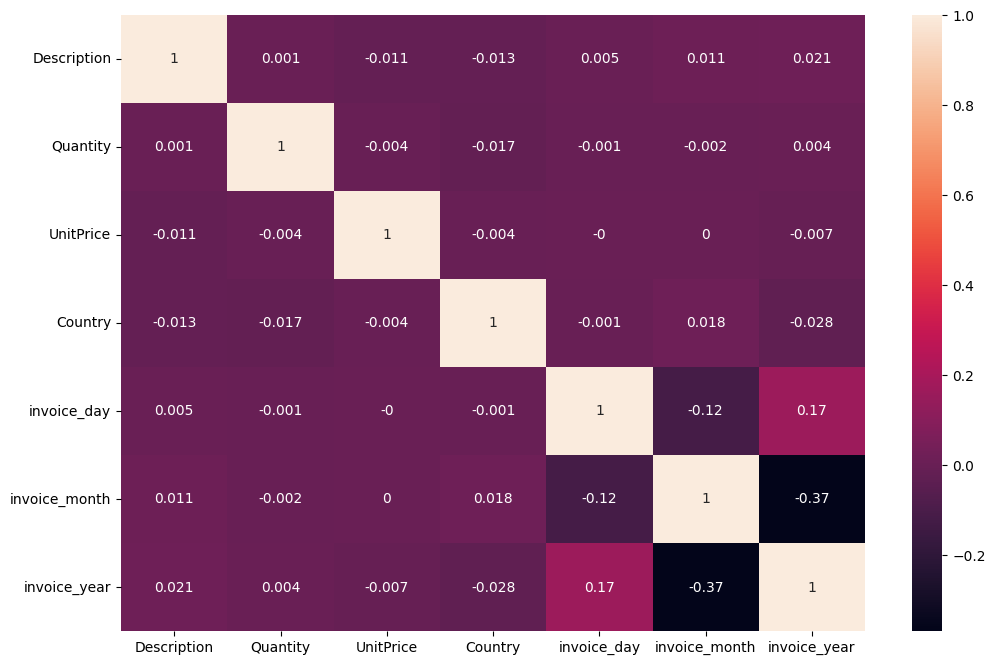

In [258]:
fig = plt.figure(figsize = (12,8))
sns.heatmap(round(df_original.select_dtypes(include=np.number).corr(), 3), annot = True)
plt.show()

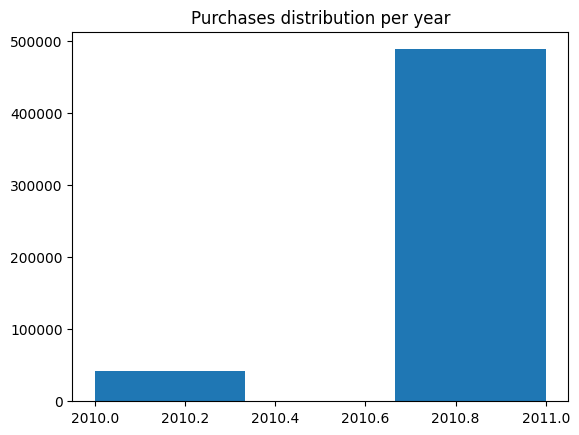

In [259]:
plt.hist(df_original["invoice_year"], bins = 3)
plt.title("Purchases distribution per year")
plt.show()

In [260]:
df = df_original.sample(20000, random_state=42)

In [261]:
df_scaled = df.copy()
for column in df_scaled.columns:
    df_scaled[column] = (df_scaled[column] - df_scaled[column].min()) / (df_scaled[column].max() - df_scaled[column].min()) 

In [262]:
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 7)
df_ = pca.fit_transform(df_scaled)

Text(0, 0.5, 'Cumulative explained variance')

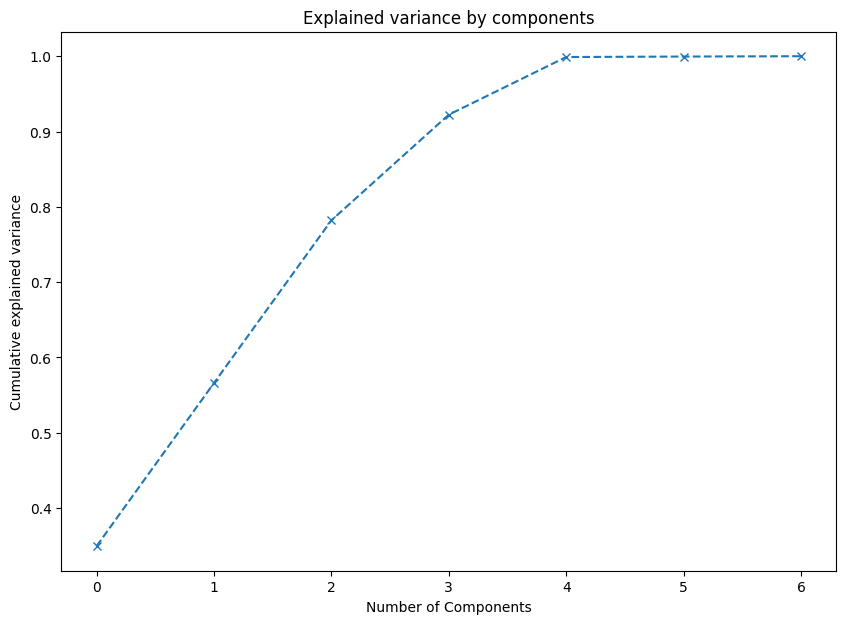

In [263]:
plt.figure(figsize = (10,7))
plt.plot(range(0,7), pca.explained_variance_ratio_.cumsum(), marker = "x", linestyle = "--")
plt.title("Explained variance by components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative explained variance")

In [264]:
pca = PCA(n_components = 2, random_state = 42)
df_scaled = pca.fit_transform(df_scaled)

In [265]:
df_scaled = pd.DataFrame(df_scaled, columns=["PCA_component1", "PCA_component2"])

<Axes: xlabel='PCA_component1', ylabel='PCA_component2'>

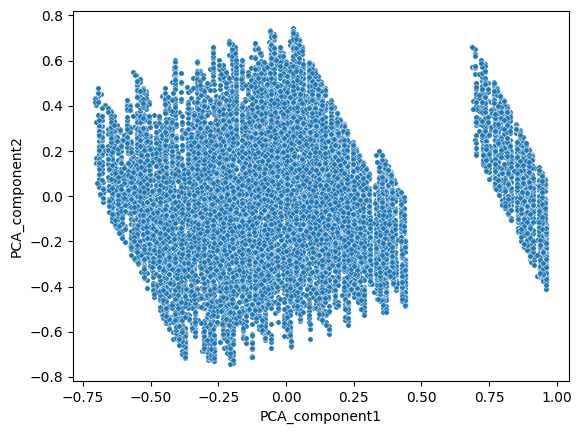

In [266]:
sns.scatterplot(data=df_scaled, x="PCA_component1", y="PCA_component2", s=15)

In [267]:
from sklearn.cluster import KMeans

clusters_centers = []
k_values = []
    
for k in range(1, 15):
        
    kmeans_model = KMeans(n_clusters = k, n_init=20, max_iter=500, random_state=42)
    kmeans_model.fit(df_scaled)
        
    clusters_centers.append(kmeans_model.inertia_)
    k_values.append(k)

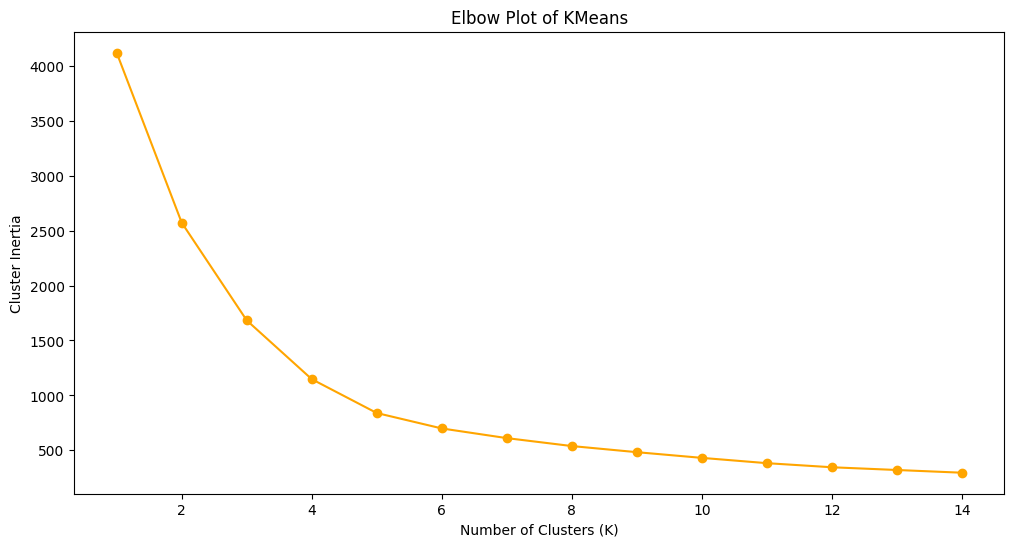

In [268]:
figure = plt.subplots(figsize = (12, 6))
plt.plot(k_values, clusters_centers, 'o-', color = 'orange')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cluster Inertia")
plt.title("Elbow Plot of KMeans")
plt.show()

In [269]:
kmeans_model = KMeans(n_clusters = 4, n_init=20, max_iter=500, random_state=42)
kmeans_model.fit(df_scaled)

KMeans(max_iter=500, n_clusters=4, n_init=20, random_state=42)

In [270]:
df['cluster'] = kmeans_model.labels_
df['cluster'].value_counts()

0    6443
3    6033
1    5965
2    1559
Name: cluster, dtype: int64

<Axes: >

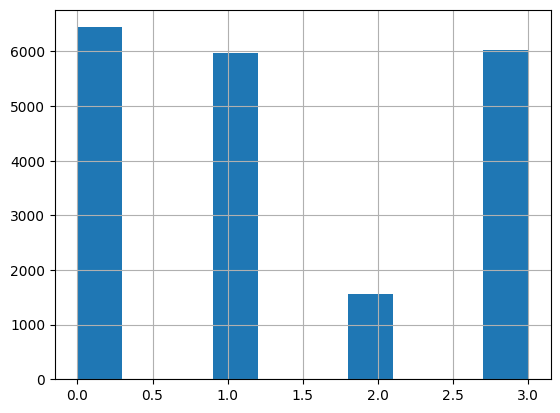

In [271]:
df['cluster'].hist()

<Axes: xlabel='PCA_component1', ylabel='PCA_component2'>

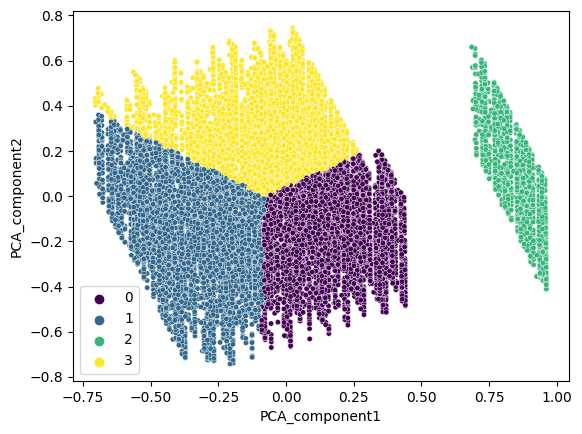

In [272]:
#sns.scatterplot(data=df_scaled,x='Quantity',y='Total Price',hue=kmeans_model.labels_,palette=['c', 'r', 'g'])palette=['c', 'r', 'g',"b"]
#plt.legend()
#plt.figure(figsize=(5,4))
sns.scatterplot(data=df_scaled, x="PCA_component1", y="PCA_component2", hue= kmeans_model.labels_, palette="viridis", s=15)

In [273]:
def columnValues(column):
    cluster0 = df.loc[df['cluster'] == 0, column].mean()
    cluster1 = df.loc[df['cluster'] == 1, column].mean()
    cluster2 = df.loc[df['cluster'] == 2, column].mean()
    cluster3 = df.loc[df['cluster'] == 3, column].mean()
    row = [cluster0, cluster1, cluster2, cluster3]
    return row

table = []
for column in df.loc[:, 'Quantity':'UnitPrice']:
    table.append([column] + columnValues(column))

print(tabulate(table, headers=["Feature","Cluster 1","Cluster 2","Cluster 3","Cluster 4"], tablefmt="orgbtl"))

Feature      Cluster 1    Cluster 2    Cluster 3    Cluster 4
---------  -----------  -----------  -----------  -----------
Quantity      10.49        11.0602       8.18794     10.2577
UnitPrice      3.35316      3.99958      3.72438      3.47591


Text(0, 0.5, 'Euclidean Distance')

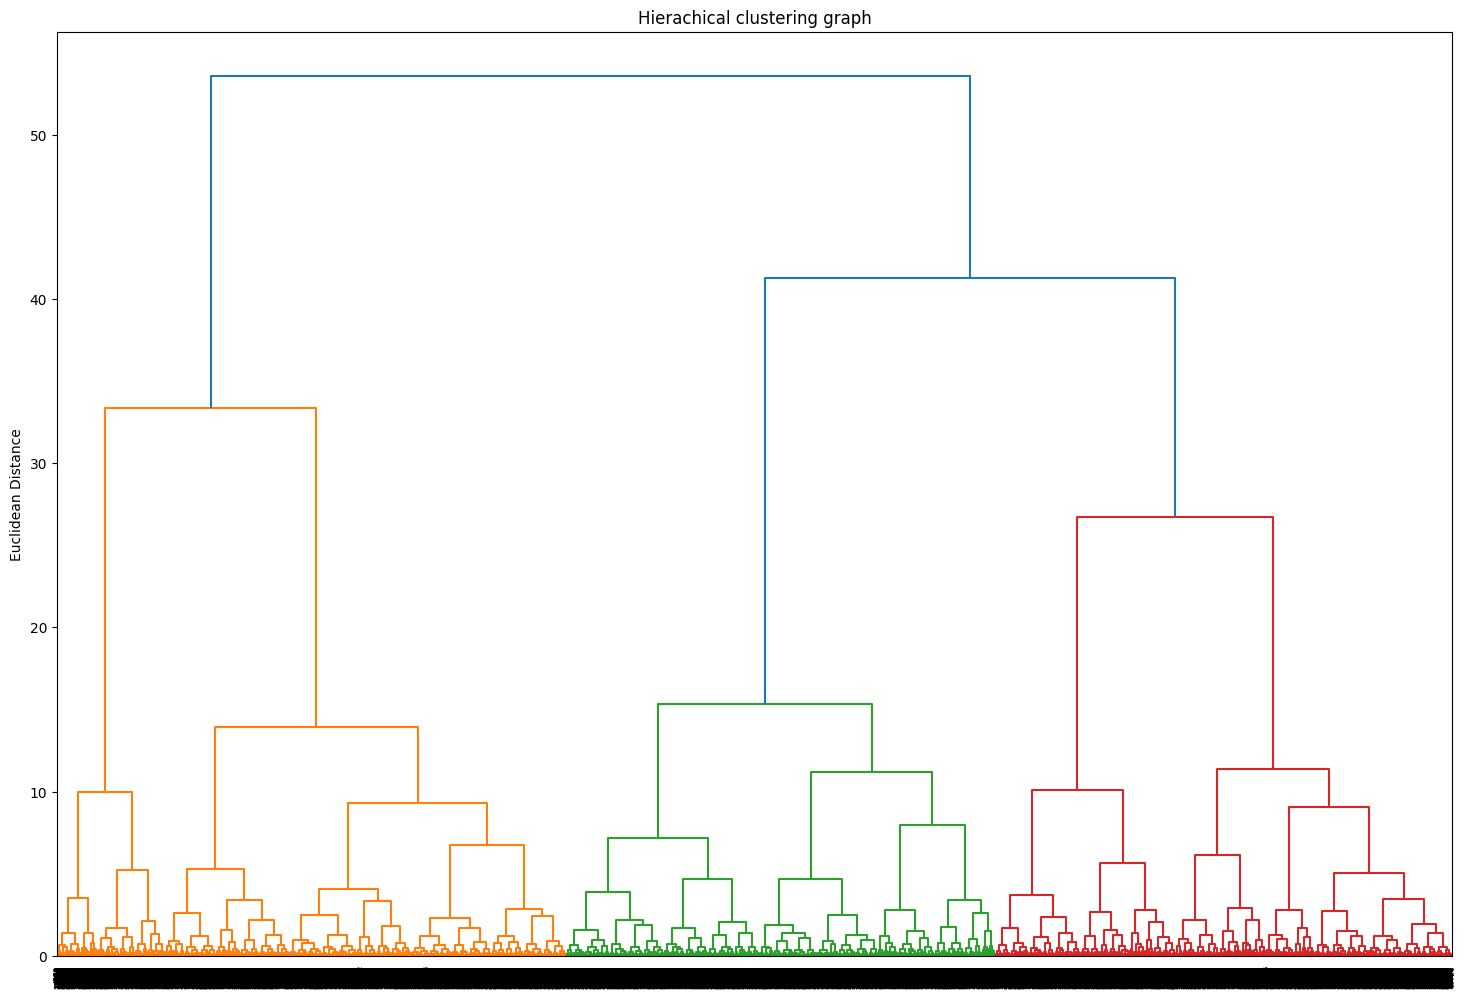

In [274]:
import scipy.cluster.hierarchy as hier

plt.figure(figsize=(18,12))
heirachical_graph=hier.dendrogram(hier.linkage(df_scaled, method='ward'))
plt.title('Hierachical clustering graph')
plt.ylabel('Euclidean Distance')

In [275]:
from sklearn.cluster import AgglomerativeClustering

AgglomerativeC = AgglomerativeClustering(n_clusters=5, metric = 'euclidean')
y_AgglomerativeC = AgglomerativeC.fit_predict(df_scaled)
df['cluster'] = y_AgglomerativeC
df['cluster'].value_counts()

0    6148
1    5750
2    3962
4    2581
3    1559
Name: cluster, dtype: int64

<Axes: >

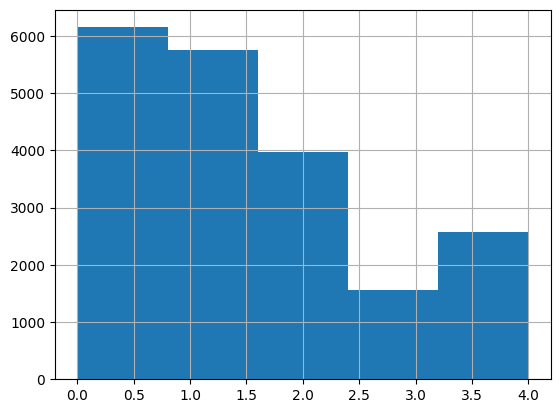

In [276]:
df['cluster'].hist(bins = 5)

<Axes: xlabel='PCA_component1', ylabel='PCA_component2'>

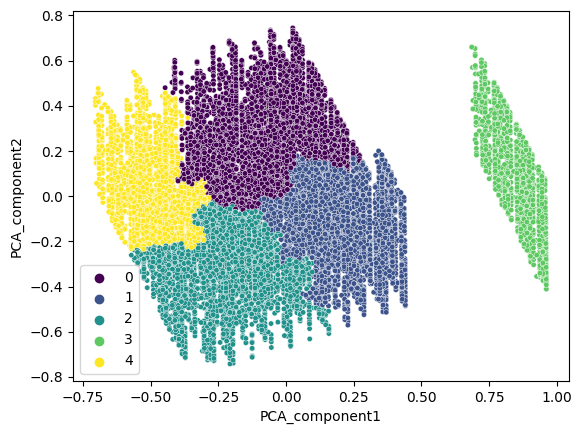

In [277]:
sns.scatterplot(data=df_scaled, x="PCA_component1", y="PCA_component2", hue= AgglomerativeC.labels_, palette="viridis", s=15)

In [278]:
def columnValues(column):
    cluster0 = df.loc[df['cluster'] == 0, column].mean()
    cluster1 = df.loc[df['cluster'] == 1, column].mean()
    cluster2 = df.loc[df['cluster'] == 2, column].mean()
    cluster3 = df.loc[df['cluster'] == 3, column].mean()
    cluster4 = df.loc[df['cluster'] == 4, column].mean()
    row = [cluster0, cluster1, cluster2, cluster3, cluster4]
    return row

table = []
for column in df.loc[:, 'Quantity':'UnitPrice']:
    table.append([column] + columnValues(column))

print(tabulate(table, headers=["Feature","Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5"], tablefmt="orgbtl"))

Feature      Cluster 1    Cluster 2    Cluster 3    Cluster 4    Cluster 5
---------  -----------  -----------  -----------  -----------  -----------
Quantity      11.2282      10.3908      10.6267       8.18794      9.51763
UnitPrice      3.54745      3.38112      3.83532      3.72438      3.86878


In [279]:
from sklearn.metrics import silhouette_score

silhouette_coefficients = []
for k in range(2, 12):  # it needs at least 2 clusters
    kmeans_model = KMeans(n_clusters = k, n_init=20, max_iter=500, random_state=42)
    kmeans_model.fit(df_scaled)
        
    score = silhouette_score(df_scaled, kmeans_model.labels_)
    silhouette_coefficients.append(score)

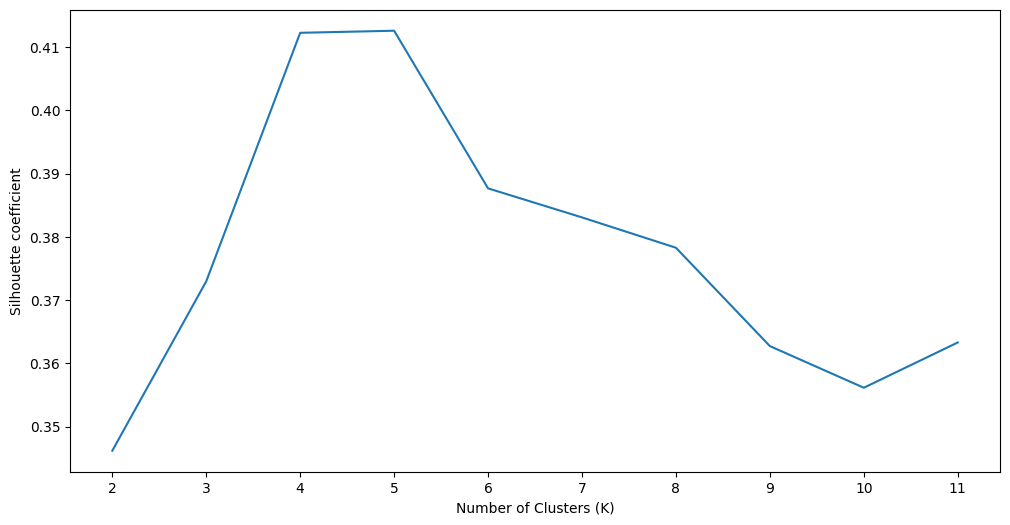

In [280]:
figure = plt.subplots(figsize = (12, 6))
plt.plot(range(2, 12), silhouette_coefficients)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette coefficient")
plt.show()

# Part 2. Supervised learning - regression

In [281]:
df = pd.read_csv("insurance.csv", sep=",")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [282]:
df.shape

(1338, 7)

In [283]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in df:
    table.append([column] + columnValues(df[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column      Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
--------  --------------  -------------  -------------  ------------  -----------  ----------  -----------
age                   47            3.5              0           0              0           0  int64
sex                    2            0.1              0           0              0           0  object
bmi                  548           41                0           0              0           0  float64
children               6            0.4            574          42.9            0           0  int64
smoker                 2            0.1              0           0              0           0  object
region                 4            0.3              0           0              0           0  object
charges             1337           99.9              0           0              0           0  float64


In [284]:
def columnValues(df):
    row = [df.mean(), df.median(), df.std(), df.min(), df.max()]
    return row

table = []
for column in df.select_dtypes(include=np.number):
    table.append([column] + columnValues(df[column]))

print(tabulate(table, headers=["Column","Mean","Median","Std","Min","Max"], tablefmt="orgbtl"))

Column           Mean    Median          Std      Min       Max
--------  -----------  --------  -----------  -------  --------
age          39.207       39        14.05       18        64
bmi          30.6634      30.4       6.09819    15.96     53.13
children      1.09492      1         1.20549     0         5
charges   13270.4       9382.03  12110        1121.87  63770.4


**EDA**

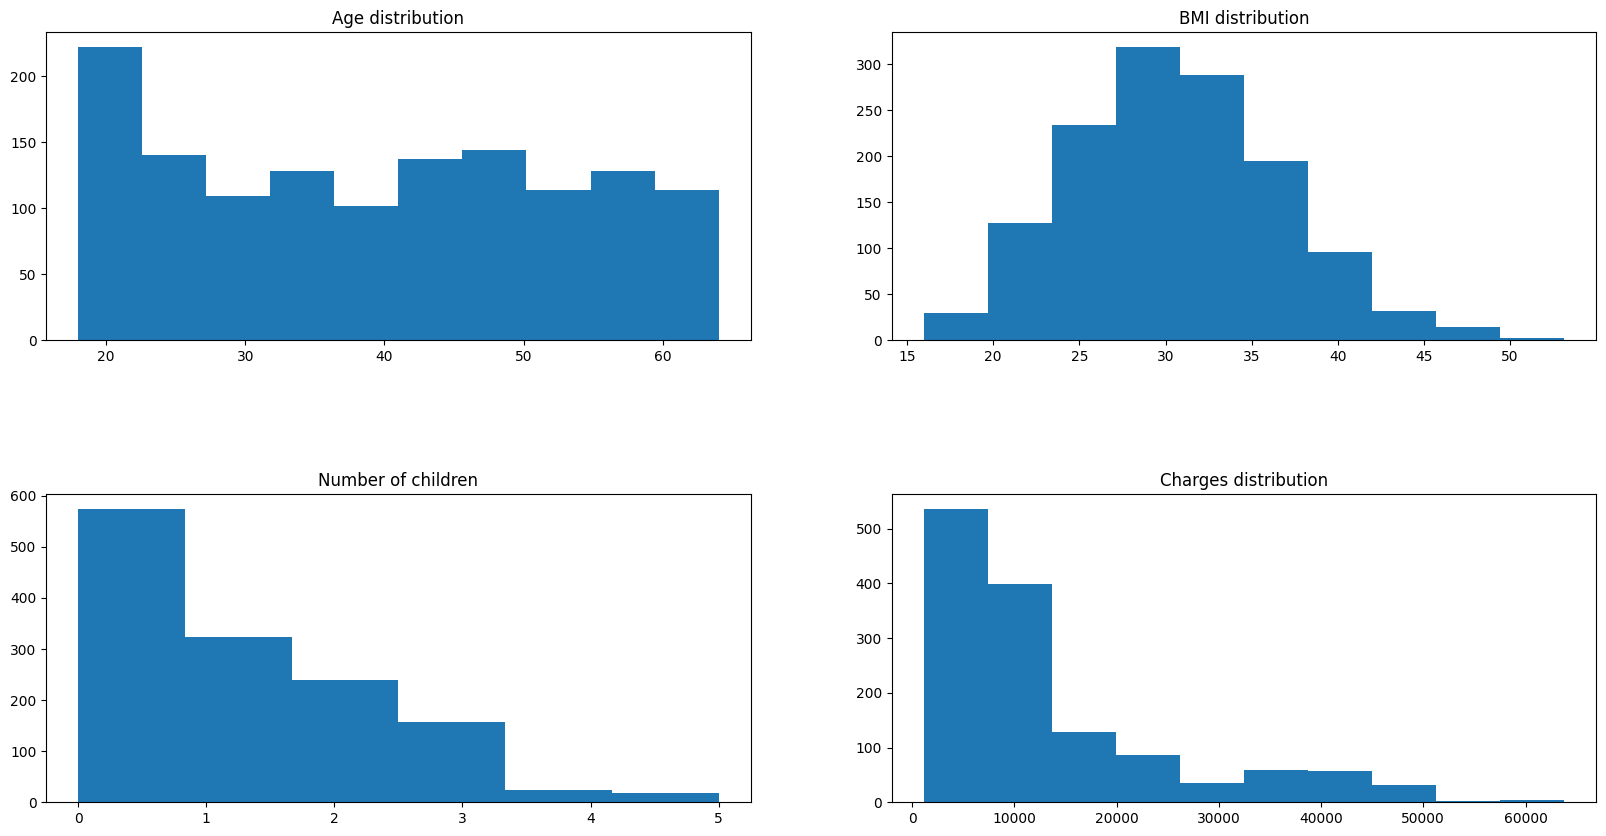

In [285]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.hist(df["age"])
plt.title("Age distribution")

plt.subplot(2, 2, 2)
plt.hist(df["bmi"])
plt.title("BMI distribution")

plt.subplot(2, 2, 3)
plt.hist(df["children"], bins=6)
plt.title("Number of children")

plt.subplot(2, 2, 4)
plt.hist(df["charges"])
plt.title("Charges distribution")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

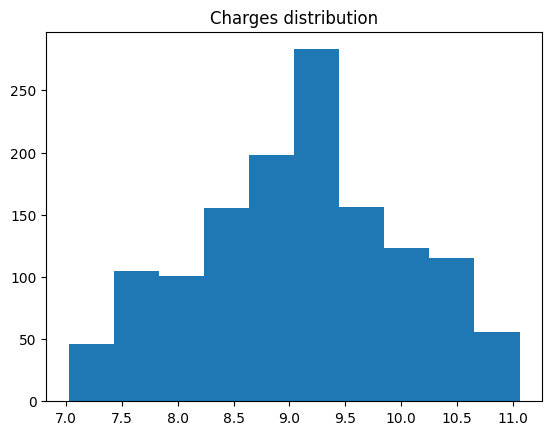

In [286]:
df["charges"] = np.log(df["charges"])
plt.hist(df["charges"])
plt.title("Charges distribution")
plt.show()

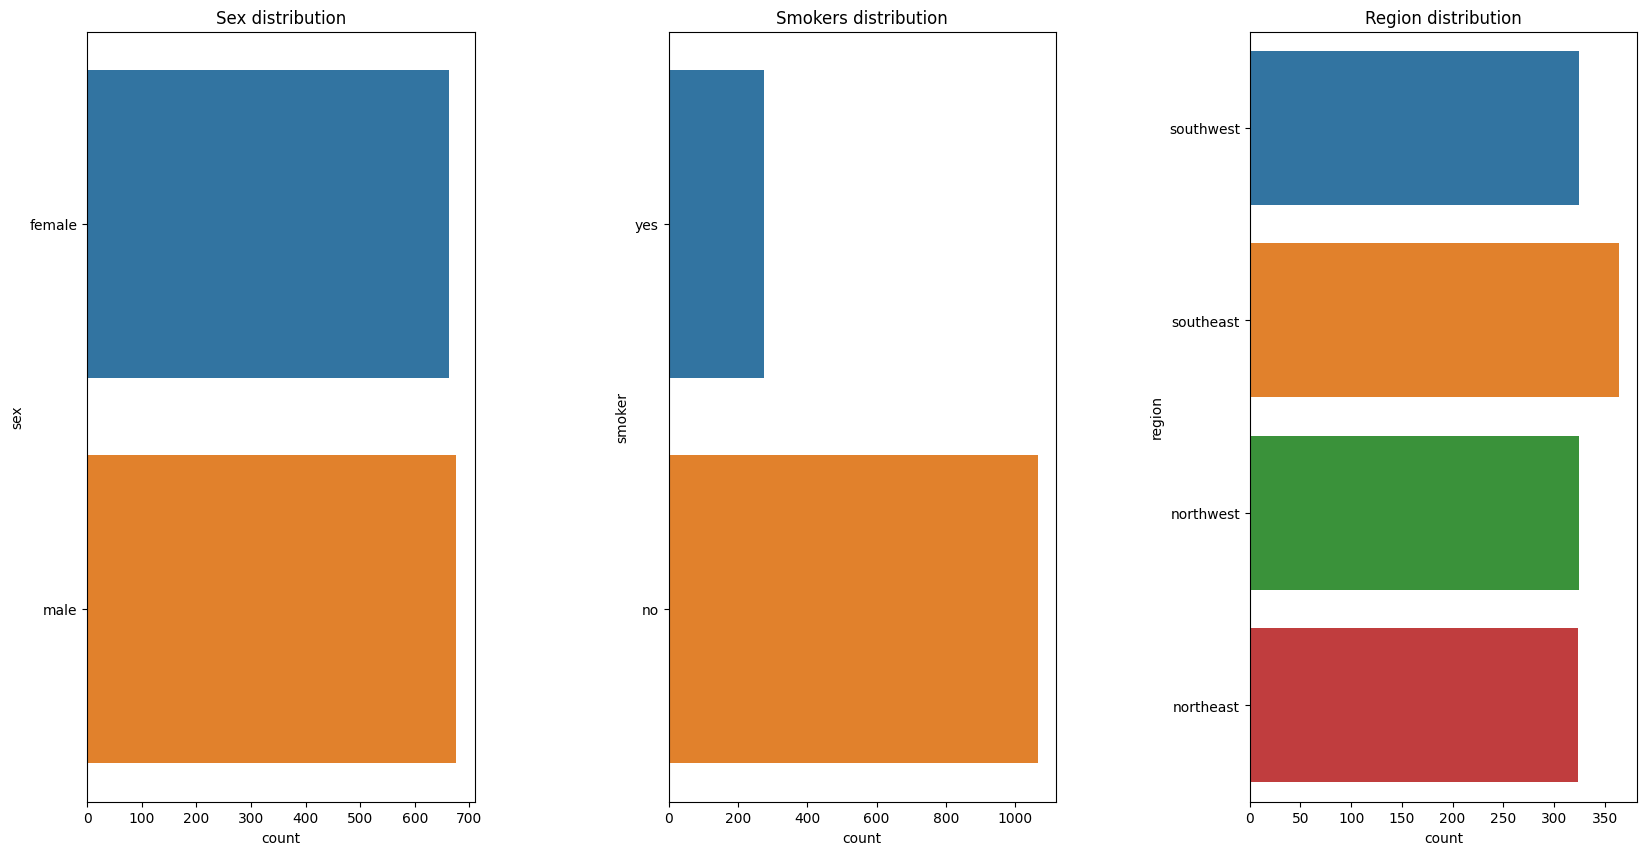

In [287]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.countplot(y='sex', data=df)
plt.title("Sex distribution")

plt.subplot(1, 3, 2)
sns.countplot(y='smoker', data=df)
plt.title("Smokers distribution")

plt.subplot(1, 3, 3)
sns.countplot(y='region', data=df)
plt.title("Region distribution")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

**Data preprocessing**

In [288]:
df["bmi_category"] = np.where(df["bmi"] < 18.5, "Underweight", 
                     np.where((df["bmi"] >= 18.5) & (df["bmi"] < 25), "Normal range", 
                     np.where((df["bmi"] >= 25) & (df["bmi"] < 30), "Overweight", "Obese")))
df['sex']=np.where(df['sex']=='female',0,1)
df['smoker']=np.where(df['smoker']=='yes',1,0)

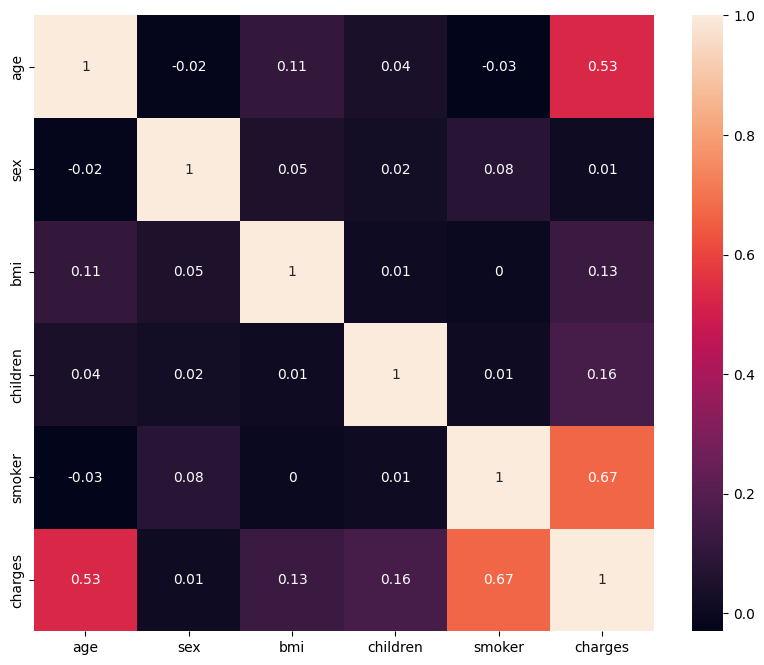

In [289]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(round(df.select_dtypes(include=np.number).corr(), 2), annot = True)
plt.show()

In [290]:
df = pd.get_dummies(df, columns = ["bmi_category", "region"])

In [291]:
X = df.drop(columns=["charges", "bmi"], axis=1)
y = df["charges"]

In [292]:
for column in X.columns:
    X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min()) 

**Building of models**

In [293]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [294]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [295]:
models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(max_depth = 5), XGBRegressor()]  # list of models for simple fit
models_names = ["LinearRegression", "Ridge", "SVR", "RandomForestRegressor","XGBRegressor"]
table = []
for i in range(5):
    models[i].fit(X_train, y_train)
  
    train_pred = models[i].predict(X_train)
    test_pred = models[i].predict(X_test)

    row = [models_names[i], round(mse(y_train, train_pred), 3), round(mse(y_test, test_pred),3), \
                  round(r2_score(y_train, train_pred),3), round(r2_score(y_test, test_pred),3)]
    table.append(row)
    
print(tabulate(table, headers=["Model","train MSE","test MSE","train R2","test R2"], tablefmt="orgbtl"))

Model                    train MSE    test MSE    train R2    test R2
---------------------  -----------  ----------  ----------  ---------
LinearRegression             0.201       0.182       0.762      0.783
Ridge                        0.201       0.182       0.762      0.782
SVR                          0.138       0.137       0.837      0.836
RandomForestRegressor        0.117       0.133       0.861      0.841
XGBRegressor                 0.024       0.199       0.971      0.762


In [296]:
from sklearn.model_selection import cross_val_score

models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(max_depth = 5, n_estimators = 100, random_state = 42, criterion='squared_error'), XGBRegressor()]  # list of models for simple fit
models_names = ["LinearRegression", "Ridge", "SVR", "RandomForestRegressor","XGBRegressor"]
table = []
for i in range(5):
    scores_mse = cross_val_score(models[i], X, y, cv=5, scoring='neg_mean_squared_error')
    scores_r2 = cross_val_score(models[i], X, y, cv=5, scoring='r2')

    row = [models_names[i], round(np.mean(-scores_mse),3), round(np.mean(scores_r2),3)]
    table.append(row)

print(tabulate(table, headers=["Model","CV MSE","CV R2"], tablefmt="orgbtl"))

Model                    CV MSE    CV R2
---------------------  --------  -------
LinearRegression          0.199    0.764
Ridge                     0.199    0.764
SVR                       0.143    0.83
RandomForestRegressor     0.139    0.835
XGBRegressor              0.197    0.766


# Part 3. Supervised learning - classification

In [297]:
df = pd.read_csv("Cancer_Data.csv", sep=",")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [298]:
df.drop(columns=["id", "Unnamed: 32"], inplace = True)

In [299]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

<Axes: ylabel='diagnosis'>

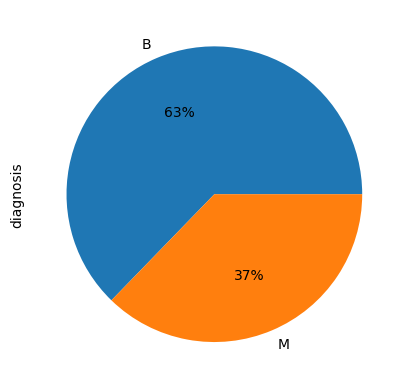

In [300]:
df['diagnosis'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [301]:
df.shape

(569, 31)

In [302]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in df:
    table.append([column] + columnValues(df[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column                     Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
-----------------------  --------------  -------------  -------------  ------------  -----------  ----------  -----------
diagnosis                             2            0.4              0           0              0           0  object
radius_mean                         456           80.1              0           0              0           0  float64
texture_mean                        479           84.2              0           0              0           0  float64
perimeter_mean                      522           91.7              0           0              0           0  float64
area_mean                           539           94.7              0           0              0           0  float64
smoothness_mean                     474           83.3              0           0              0           0  float64
compactness_mean                    537           9

In [303]:
def columnValues(df):
    row = [df.mean(), df.median(), df.std(), df.min(), df.max()]
    return row

table = []
for column in df.select_dtypes(include=np.number):
    table.append([column] + columnValues(df[column]))

print(tabulate(table, headers=["Column","Mean","Median","Std","Min","Max"], tablefmt="orgbtl"))

Column                           Mean      Median           Std          Min         Max
-----------------------  ------------  ----------  ------------  -----------  ----------
radius_mean               14.1273       13.37        3.52405       6.981        28.11
texture_mean              19.2896       18.84        4.30104       9.71         39.28
perimeter_mean            91.969        86.24       24.299        43.79        188.5
area_mean                654.889       551.1       351.914       143.5        2501
smoothness_mean            0.0963603     0.09587     0.0140641     0.05263       0.1634
compactness_mean           0.104341      0.09263     0.0528128     0.01938       0.3454
concavity_mean             0.0887993     0.06154     0.0797198     0             0.4268
concave points_mean        0.0489191     0.0335      0.0388028     0             0.2012
symmetry_mean              0.181162      0.1792      0.0274143     0.106         0.304
fractal_dimension_mean     0.0627976     0.

**EDA**

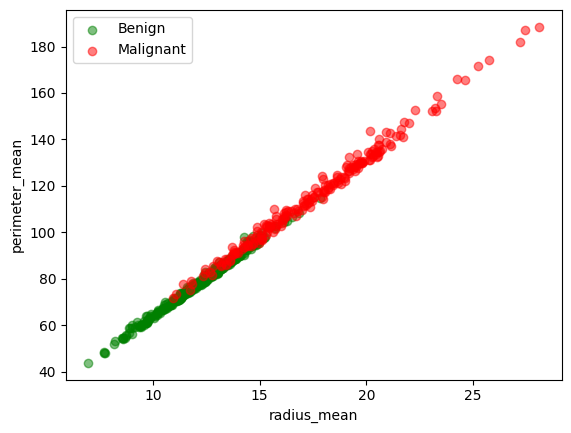

In [304]:
plt.scatter(df.loc[df["diagnosis"] == "B"].radius_mean,df.loc[df["diagnosis"] == "B"].perimeter_mean, color = "green", label = "Benign", alpha = 0.5)
plt.scatter(df.loc[df["diagnosis"] == "M"].radius_mean,df.loc[df["diagnosis"] == "M"].perimeter_mean, color = "red", label = "Malignant", alpha = 0.5)

plt.xlabel("radius_mean")
plt.ylabel("perimeter_mean")

plt.legend()
plt.show()

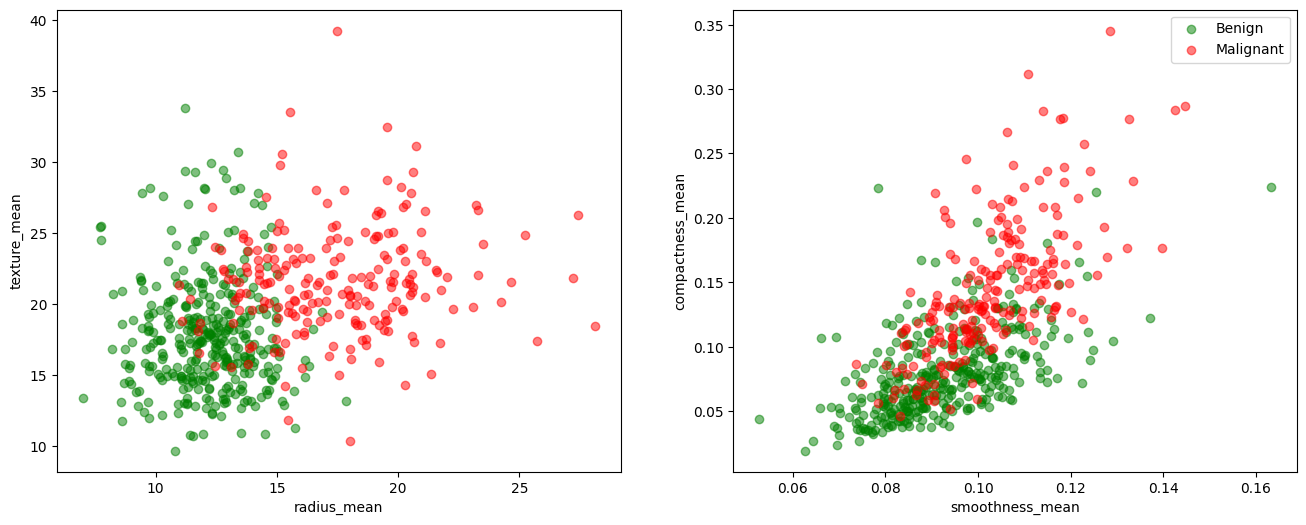

In [305]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(df.loc[df["diagnosis"] == "B"].radius_mean,df.loc[df["diagnosis"] == "B"].texture_mean, color = "green", label = "Benign", alpha = 0.5)
plt.scatter(df.loc[df["diagnosis"] == "M"].radius_mean,df.loc[df["diagnosis"] == "M"].texture_mean, color = "red", label = "Malignant", alpha = 0.5)
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")

plt.subplot(1, 2, 2)
plt.scatter(df.loc[df["diagnosis"] == "B"].smoothness_mean,df.loc[df["diagnosis"] == "B"].compactness_mean, color = "green", label = "Benign", alpha = 0.5)
plt.scatter(df.loc[df["diagnosis"] == "M"].smoothness_mean,df.loc[df["diagnosis"] == "M"].compactness_mean, color = "red", label = "Malignant", alpha = 0.5)
plt.xlabel("smoothness_mean")
plt.ylabel("compactness_mean")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.legend()
plt.show()

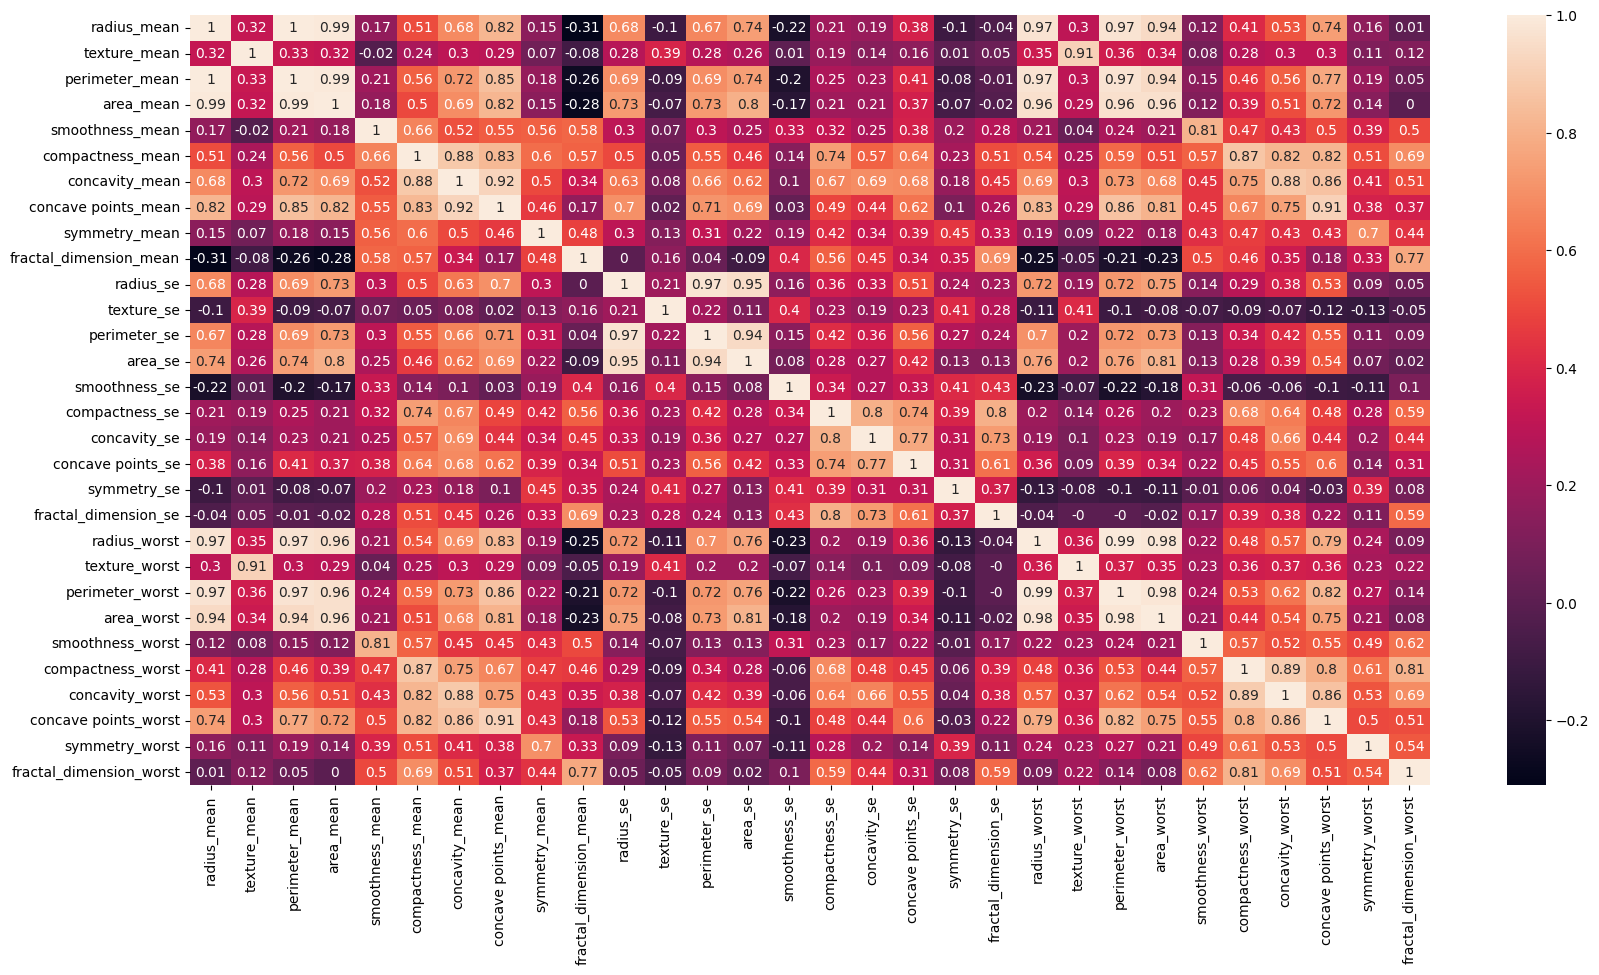

In [306]:
fig = plt.figure(figsize = (20,10))
sns.heatmap(round(df.select_dtypes(include=np.number).corr(), 2), annot = True)
plt.show()

**Data preprocessing**

In [307]:
df['diagnosis']=np.where(df['diagnosis']=='B',0,1)

In [308]:
X = df.drop(columns=["diagnosis"], axis=1)
y = df["diagnosis"]

In [309]:
for column in X.columns:
    X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min()) 

In [310]:
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 10)
df_ = pca.fit_transform(X)

Text(0, 0.5, 'Cumulative explained variance')

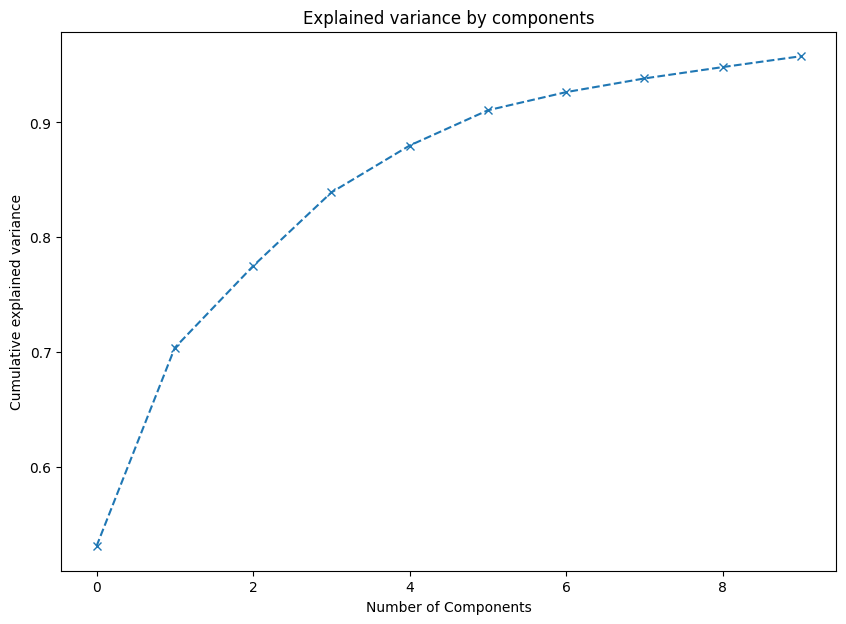

In [311]:
plt.figure(figsize = (10,7))
plt.plot(range(0,10), pca.explained_variance_ratio_.cumsum(), marker = "x", linestyle = "--")
plt.title("Explained variance by components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative explained variance")

In [312]:
pca = PCA(n_components = 2)
  
X = pca.fit_transform(X)

**Building of models**

In [313]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [314]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [317]:
models = [LogisticRegression(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), GradientBoostingClassifier()]  # list of models for simple fit
models_names = ["LogisticRegression", "LDA", "QDA", "GradientBoostingClassifier"]
table = []
for i in range(4):
    models[i].fit(X_train, y_train)
  
    train_pred = models[i].predict(X_train)
    test_pred = models[i].predict(X_test)

    row = [models_names[i], round(roc_auc_score(y_train, train_pred), 3), round(roc_auc_score(y_test, test_pred),3), \
                  round(f1_score(y_train, train_pred),3), round(f1_score(y_test, test_pred),3)]
    table.append(row)
    
print(tabulate(table, headers=["Model","train ROC-AUC","test ROC-AUC","train F1 score","test F1 score"], tablefmt="orgbtl"))

Model                         train ROC-AUC    test ROC-AUC    train F1 score    test F1 score
--------------------------  ---------------  --------------  ----------------  ---------------
LogisticRegression                    0.94            0.935             0.931            0.926
LDA                                   0.913           0.944             0.903            0.941
QDA                                   0.929           0.926             0.912            0.911
GradientBoostingClassifier            0.997           0.956             0.997            0.951


In [316]:
from sklearn.model_selection import cross_val_score

models = [LogisticRegression(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), GradientBoostingClassifier()]  # list of models for simple fit
models_names = ["LogisticRegression", "LDA", "QDA", "GradientBoostingClassifier"]
table = []
for i in range(4):
    scores_roc_auc = cross_val_score(models[i], X, y, cv=5, scoring='roc_auc')
    scores_f1 = cross_val_score(models[i], X, y, cv=5, scoring='f1')

    row = [models_names[i], round(np.mean(scores_roc_auc),3), round(np.mean(scores_f1),3)]
    table.append(row)

print(tabulate(table, headers=["Model","CV ROC-AUC","CV F1"], tablefmt="orgbtl"))

Model                         CV ROC-AUC    CV F1
--------------------------  ------------  -------
LogisticRegression                 0.988    0.919
LDA                                0.987    0.908
QDA                                0.984    0.914
GradientBoostingClassifier         0.982    0.924
